# Plot sam_planck

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# import black
# import jupyter_black

# jupyter_black.load(
#     lab=False,
#     line_length=79,
#     verbosity="DEBUG",
#     target_version=black.TargetVersion.PY310,
# )

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/home/jchaves/Proyectos/projects/lya/cup1d/notebooks/


## Read Data

### Options

In [2]:

from matplotlib.ticker import MaxNLocator
from lace.archive import gadget_archive, nyx_archive
from cup1d.likelihood import lya_theory
from lace.cosmo.camb_cosmo import (
    get_camb_results,
    get_Nyx_cosmology,
    get_cosmology_from_dictionary,
)
from lace.cosmo.fit_linP import parameterize_cosmology_kms
from cup1d.likelihood import CAMB_model

In [3]:
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig
import pandas as pd

In [84]:
folder = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/v3/emu_Pedersen23_ext/cov_Chabanier2019/mock_Chabanier19_igm_mpg_central_cosmo_mpg_central_nigm_2_smooth/chain_5/"
folder = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/v3/emu_CH24/cov_Chabanier2019/mock_Chabanier19_igm_mpg_central_cosmo_mpg_central_nigm_2_smooth/chain_1/"

chain = np.load(folder + 'chain.npy')
lnprob = np.load(folder + 'lnprob.npy')

In [85]:
lnprob.shape

(1360000,)

In [86]:
lnprob = lnprob.reshape(2125, 32*20)

In [87]:
chain = chain.reshape(2125, 32*20, 12)

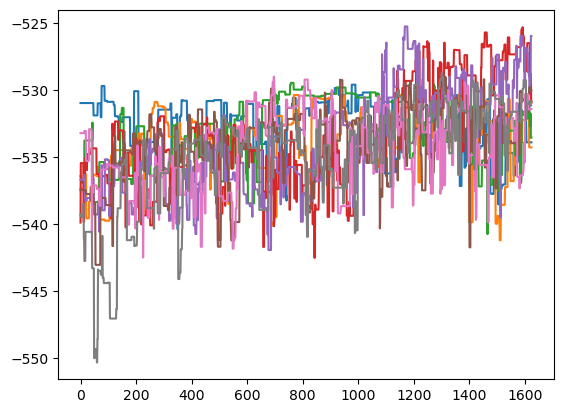

In [100]:
nburn = 500
mask = np.zeros((lnprob.shape[1]), dtype=bool)
for ii in range(32*20):
    if((np.median(lnprob[nburn:,ii]) > -535) & (lnprob[nburn,ii] > -540)):
    # if((np.median(lnprob[nburn:,ii]) > -540)):
        plt.plot(lnprob[nburn:,ii])
        mask[ii] = True

In [95]:
from corner import corner

In [101]:
chain_mask = chain[:, mask, :].reshape(-1, 12)

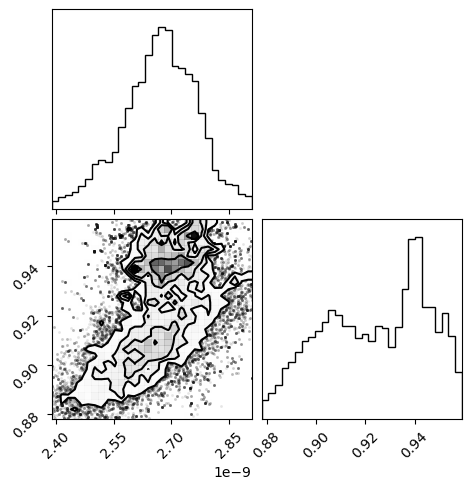

In [97]:
corner(chain_mask[:, :2], bins=30, range=[0.98, 0.98]);
plt.savefig("test_chabanier19_pla.png")

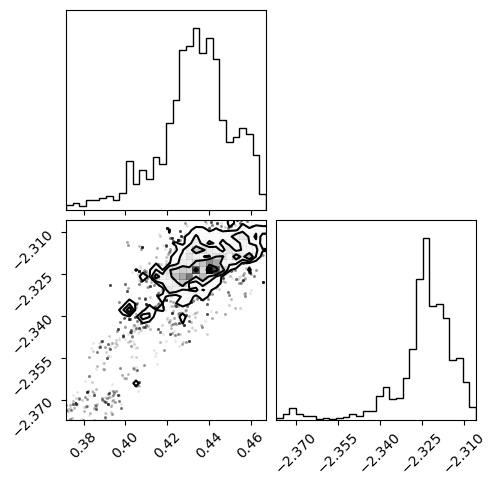

In [102]:
corner(chain_mask[:, -2:], bins=30, range=[0.98, 0.98]);
# plt.savefig("test_chabanier19_P23.png")
plt.savefig("test_chabanier19_CH24.png")

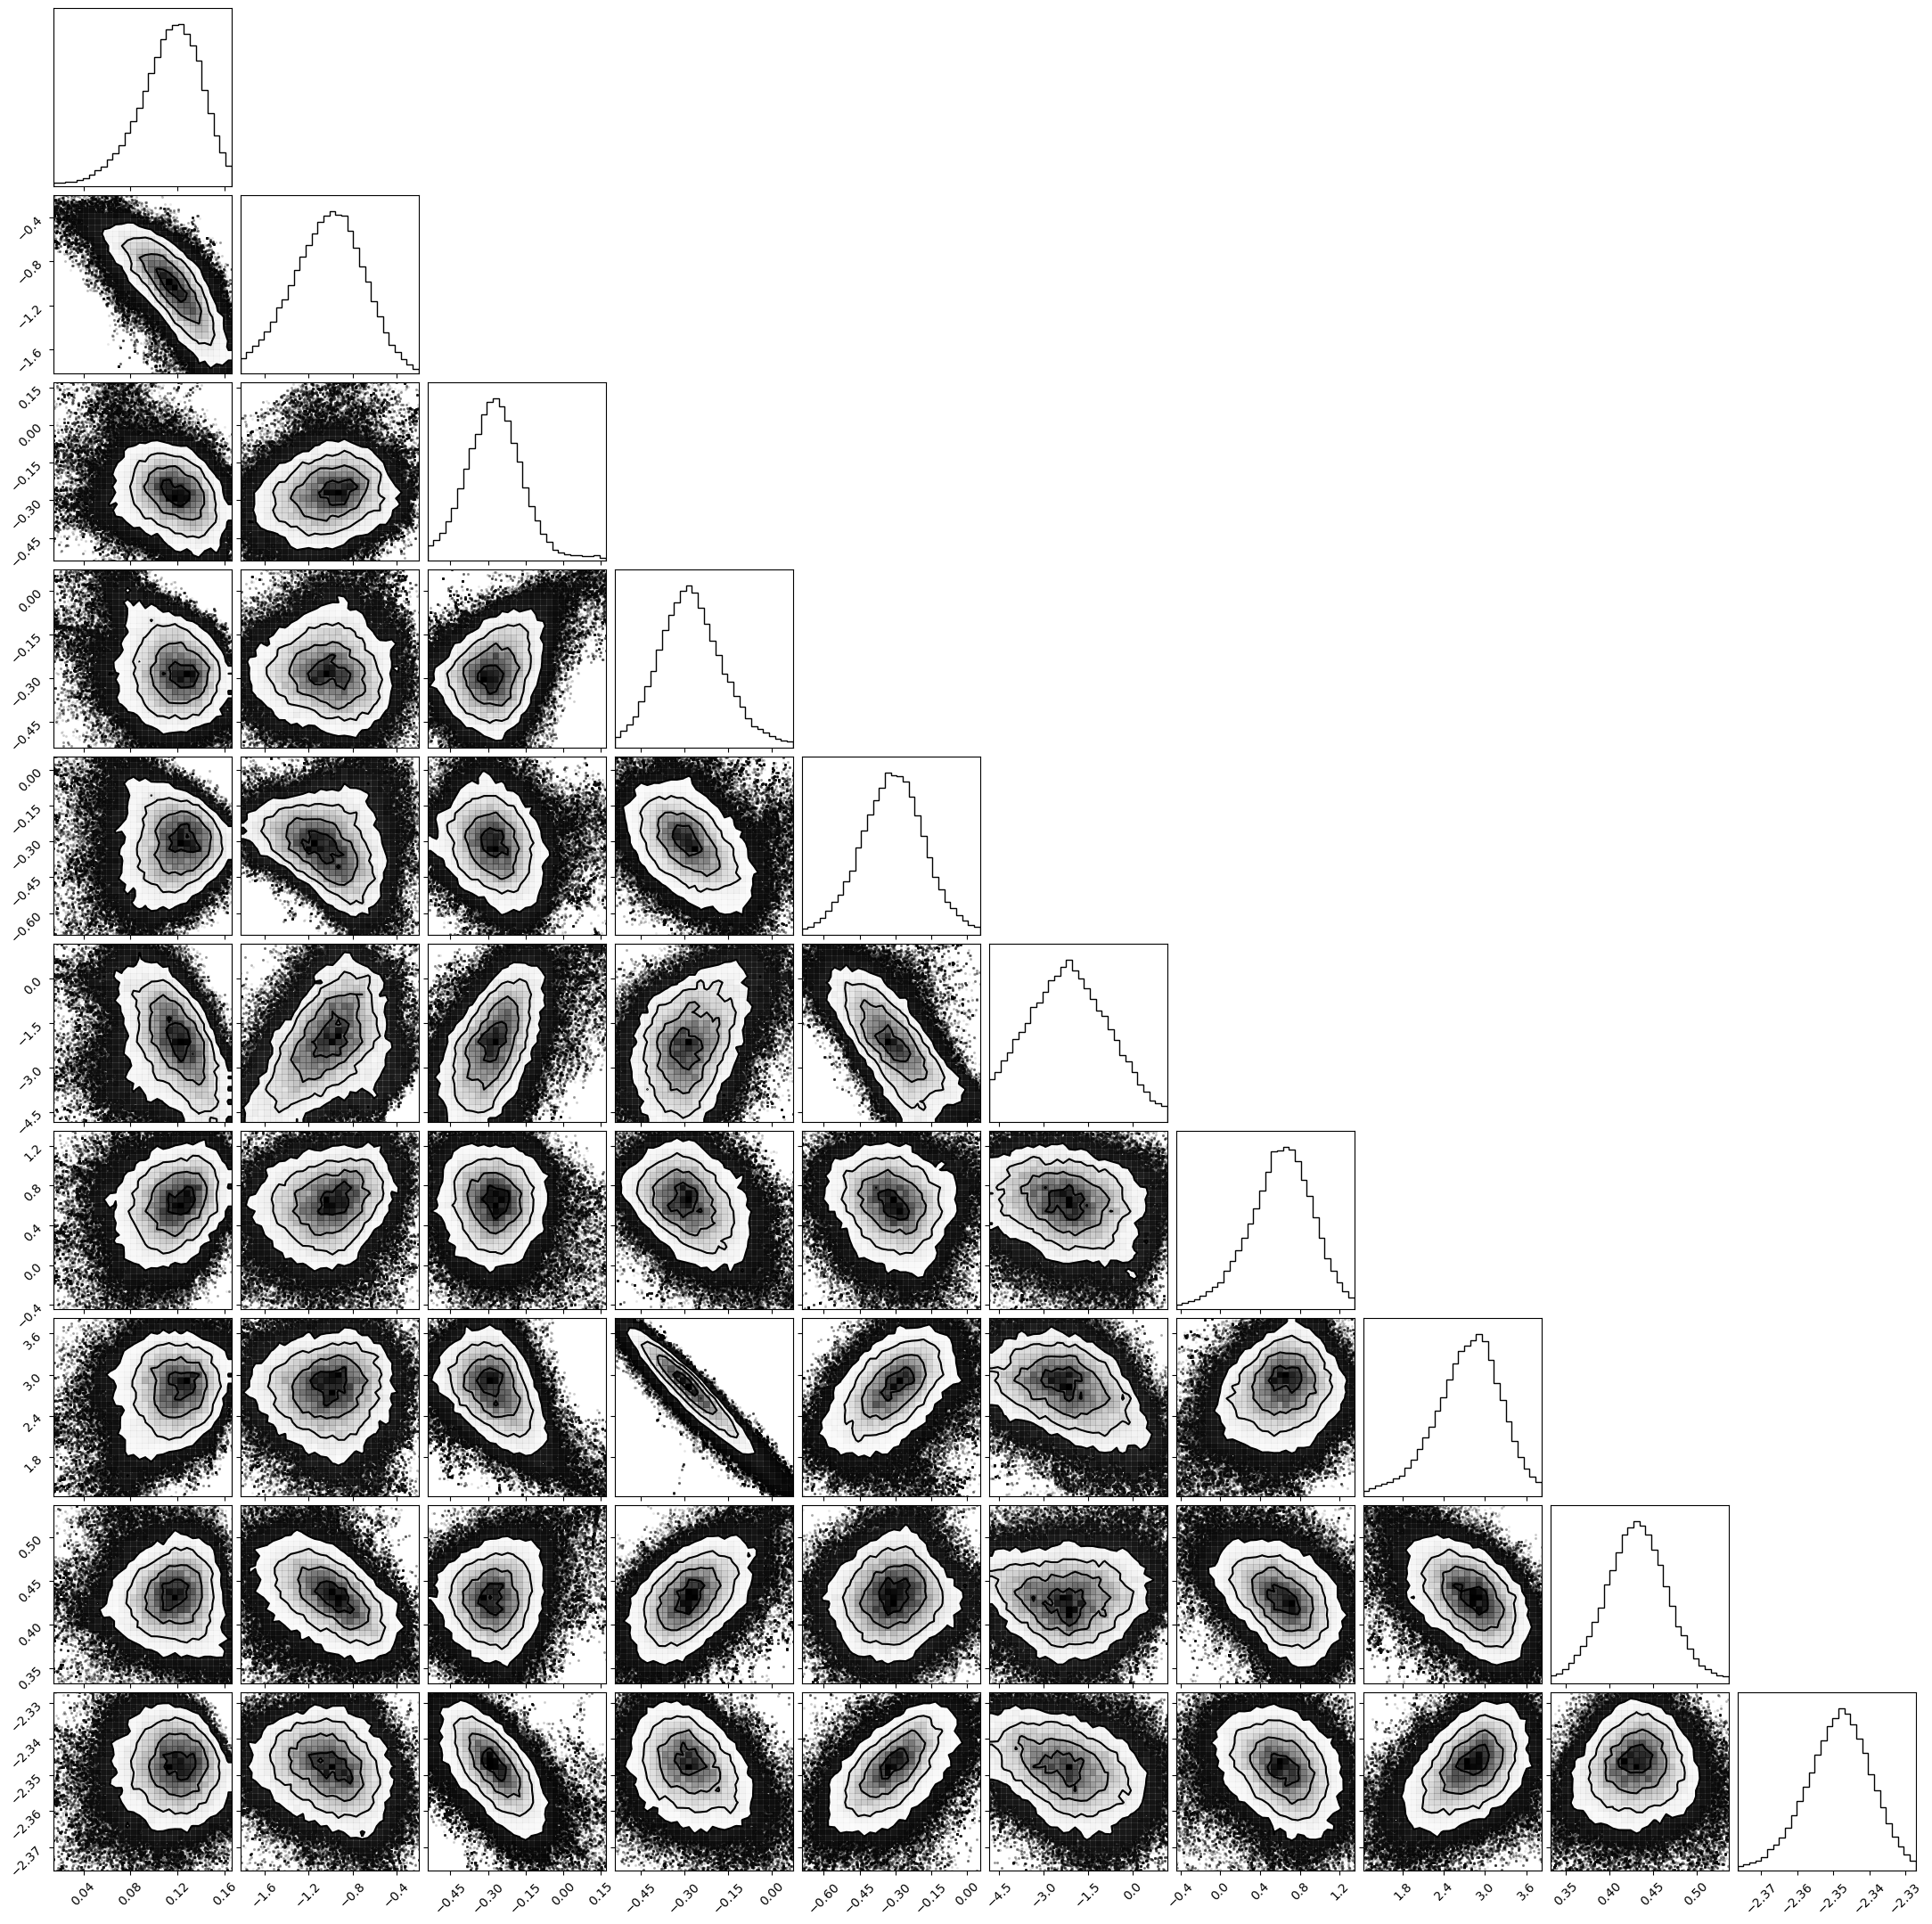

In [81]:
corner(chain_mask[:, 2:], bins=30, range=list(np.zeros(10)+0.98));
plt.savefig("test_chabanier19_all_P23.png")
# plt.savefig("test_chabanier19_all_CH24.png")

In [104]:
bool("False")

True

#### load planck

In [55]:
par_names = ["$A_s/A^\mathrm{fid}_s-1$", "$n_s/n^\mathrm{fid}_s-1$"]

In [57]:
fnames = "/home/jchaves/Proyectos/projects/lya/data/planck/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE.paramnames"
_ = np.loadtxt(fnames, dtype="str")
planck_names = _[:, 0]
planck_names_descr = _[:, 1]

dict_plack = {"w": [], par_names[0]: [], par_names[1]: []}
fchain = "/home/jchaves/Proyectos/projects/lya/data/planck/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_"
for ii in range(1, 5):
    file = np.loadtxt(fchain + str(ii) + ".txt")
    dict_plack["w"].append(file[:, 0])
    #     dict_plack["lnprop"].append(file[:, 1])
    dict_plack[par_names[0]].append(np.exp(file[:, 6]) / 1e10)
    dict_plack[par_names[1]].append(file[:, 7])
for par in dict_plack:
    dict_plack[par] = np.concatenate(dict_plack[par])

dict_plack[par_names[0]] = (
    dict_plack[par_names[0]] / np.median(dict_plack[par_names[0]]) - 1
)
dict_plack[par_names[1]] = (
    dict_plack[par_names[1]] / np.median(dict_plack[par_names[1]]) - 1
)

#### load cabayol23

In [6]:
fchain_cabayol = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Cabayol23_lres/Cabayol23_Chabanier2019_mpg_central_igm2_ydrop_ypoly/chain_1_extended/chain.npy"
chain_cabayol = np.load(fchain_cabayol)
fsum_cabayol = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Cabayol23_lres/Cabayol23_Chabanier2019_mpg_central_igm2_ydrop_ypoly/chain_1_extended/results.npy"
sum_cabayol = np.load(fsum_cabayol, allow_pickle=True).item()

dict_cabayol23 = {
    "$\Delta A_s$": chain_cabayol[:, 0] - sum_cabayol["truth"]["$A_s$"],
    "$\Delta n_s$": chain_cabayol[:, 1] - sum_cabayol["truth"]["$n_s$"],
}

### load nyx

In [6]:
fchain_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_Chabanier2019_nyx_central_igm2_ydrop_ypoly/chain_1_extended/chain.npy"
chain_nyx = np.load(fchain_nyx)
fsum_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_Chabanier2019_nyx_central_igm2_ydrop_ypoly/chain_1_extended/results.npy"
sum_nyx = np.load(fsum_nyx, allow_pickle=True).item()

# dict_nyx23 = {
#     "$\Delta A_s$": chain_nyx[:, 0] - sum_nyx["truth"]["$A_s$"],
#     "$\Delta n_s$": chain_nyx[:, 1] - sum_nyx["truth"]["$n_s$"],
# }

dict_nyx23 = {
    par_names[0]: chain_nyx[:, 0] / np.median(chain_nyx[:, 0]) - 1,
    par_names[1]: chain_nyx[:, 1] / np.median(chain_nyx[:, 1]) - 1,
}

In [7]:
fchain_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_QMLE_Ohio_nyx_central_igm2_ydrop_ypoly/chain_1/chain.npy"
chain_nyx = np.load(fchain_nyx)
fsum_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_QMLE_Ohio_nyx_central_igm2_ydrop_ypoly/chain_1/results.npy"
sum_nyx = np.load(fsum_nyx, allow_pickle=True).item()

# dict_nyx23b = {
#     "$\Delta A_s$": chain_nyx[:, 0] - sum_nyx["truth"]["$A_s$"],
#     "$\Delta n_s$": chain_nyx[:, 1] - sum_nyx["truth"]["$n_s$"],
# }


dict_nyx23b = {
    par_names[0]: chain_nyx[:, 0] / np.median(chain_nyx[:, 0]) - 1,
    par_names[1]: chain_nyx[:, 1] / np.median(chain_nyx[:, 1]) - 1,
}

## plot

In [63]:
c = ChainConsumer()

In [64]:
pd_planck = pd.DataFrame(data=dict_plack)
chain = Chain(samples=pd_planck, weight_column="w", name="Planck")
c.add_chain(chain)

In [10]:
# pd_mpg = pd.DataFrame(data=dict_cabayol23)
# chain = Chain(samples=pd_mpg, name="LaCE mpg")
# c.add_chain(chain)

In [11]:
pd_nyx = pd.DataFrame(data=dict_nyx23)
chain = Chain(samples=pd_nyx, name="Emulator eBOSS")
c.add_chain(chain)

pd_nyx = pd.DataFrame(data=dict_nyx23b)
chain = Chain(samples=pd_nyx, name="Emulator DESI")
c.add_chain(chain)

In [60]:
c.add_truth(
    Truth(
        location={
            par_names[0]: 0,
            par_names[1]: 0,
        },
        line_style=":",
        color="black",
    )
)

In [61]:
c.set_plot_config(
    PlotConfig(
        extents={
            par_names[0]: (-0.25, 0.25),
            par_names[1]: (-0.025, 0.025),
        }
    )
)

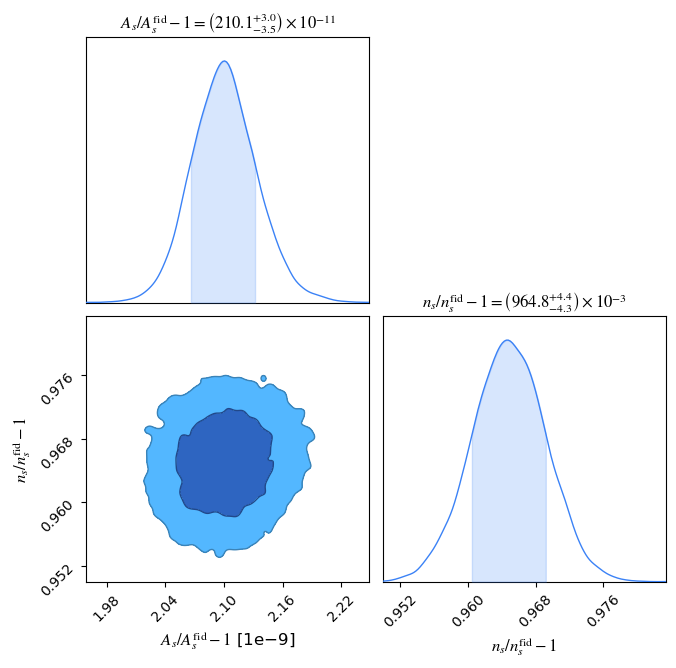

In [65]:
fig = c.plotter.plot()

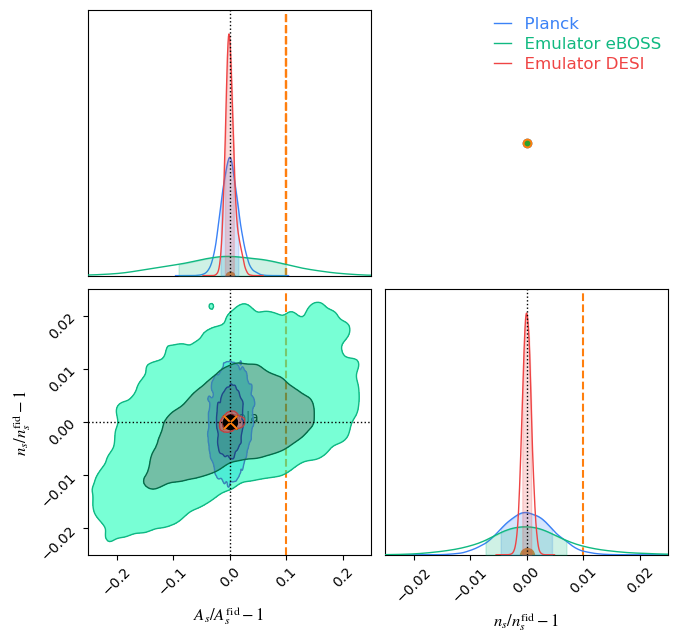

In [62]:
fig

In [61]:
# fig.axes[2].scatter(0, 0, s=100, color='C1', marker='x', zorder=10)
fig.axes[0].axvline(0.1, color="C1", ls="--")
fig.axes[3].axvline(0.01, color="C1", ls="--")
# fig.axes[2].text(0, 0, 'hola')

In [87]:
fig.savefig(
    "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/fig/compare_central.pdf"
)
fig.savefig(
    "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/fig/compare_central.png"
)